# Unsupervised Learning on Burning Man Festival Events Data

<a href='#pca'> Jump to PCA </a>

<a href='#tsvd'> Jump to TSVD </a>

<a href='#tsne'> Jump to TSNE </a>

In [1]:
import pandas as pd;
import numpy as np;
import seaborn as sns;
import matplotlib.pyplot as plt;

import string, nltk, re, pprint

from functools import reduce
from tqdm import tqdm
from pylab import *;
from scipy import sparse
from random import random

from nltk.corpus   import stopwords
from nltk          import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
from nltk.corpus import stopwords

from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, mean_squared_error;
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV

import lightgbm as lgb;

from wordcloud import WordCloud, STOPWORDS

eng_stopwords = set(stopwords.words("english"))

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


# Construct Feature Engineered Dataset

In [2]:
events = pd.read_csv('raw_data/cleaned_up.csv')

le = LabelEncoder()
le.fit(events['Type'].values)
labels = le.classes_
y = le.transform(events['Type'].values) 

events["Description"] = (events["Description"].map(str) + ' ' + 
                         events["Title"].map(str) + ' ' + 
                         events["Hosted by Camp"].map(str) + ' ' + 
                         events["Location"].map(str))
events = events.drop(['Title', 'Hosted by Camp', 'Location'], axis=1)

In [3]:
def convert_12_to_24(time):
    if 'a.m.' in time:
        time = time.replace(' a.m.', '')
        if ':' not in time:
            time = time + ':00'    
    elif 'p.m.' in time:
        time = time.replace(' p.m.', '')
        if ':' not in time:
            if '12' in time:
                time = time + ':00'
            else:
                time = str(int(time)+12) + ':00'
        elif '12' in time:
            pass
        else:
            time_split = time.split(':')
            time = str(int(time_split[0])+12) + ':' + time_split[1]
    elif 'midnight' in time:
        time = '23:45'
    elif 'noon' in time:
        time = '12:00'
            
    return time

def get_time_diff(df):      
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append((datetime.datetime.strptime('23:59', '%H:%M')-datetime.datetime.strptime('00:00', '%H:%M')).total_seconds()/3600)
        else:
            split = row.split(' – ');
            
            split[0] = convert_12_to_24(split[0])
            split[1] = convert_12_to_24(split[1])

            times.append((datetime.datetime.strptime(split[1], '%H:%M')-datetime.datetime.strptime(split[0], '%H:%M')).total_seconds()/3600)
    
    return times;

def get_start_times(df):      
    times = [];

    for row in tqdm(df.values): 
        if row == '0':
            times.append(np.nan);
        elif row == 'All Day':
            times.append(0)
        else:
            split = row.split(' – ');
            time = datetime.datetime.strptime(convert_12_to_24(split[0]), '%H:%M')
            times.append(60*time.hour + time.minute)
    
    return times;

In [4]:
times_1 = pd.DataFrame(get_time_diff(events['Sunday']),    columns=['Event Length'])
times_2 = pd.DataFrame(get_time_diff(events['Monday']),    columns=['Event Length'])
times_3 = pd.DataFrame(get_time_diff(events['Tuesday']),   columns=['Event Length'])
times_4 = pd.DataFrame(get_time_diff(events['Wednesday']), columns=['Event Length'])
times_5 = pd.DataFrame(get_time_diff(events['Thursday']),  columns=['Event Length'])
times_6 = pd.DataFrame(get_time_diff(events['Friday']),    columns=['Event Length'])
times_7 = pd.DataFrame(get_time_diff(events['Saturday']),  columns=['Event Length'])
times_8 = pd.DataFrame(get_time_diff(events['Sunday2']),   columns=['Event Length'])
times_9 = pd.DataFrame(get_time_diff(events['Monday2']),   columns=['Event Length'])

times = times_1.fillna(times_2).fillna(times_3).fillna(times_4).fillna(times_5).fillna(times_6).fillna(times_7).fillna(times_8).fillna(times_9)

events['Event Length'] = abs(times)

100%|███████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 1119306.28it/s]


In [5]:
start_times_1 = pd.DataFrame(get_start_times(events['Sunday']),    columns=['Start Time'])
start_times_2 = pd.DataFrame(get_start_times(events['Monday']),    columns=['Start Time'])
start_times_3 = pd.DataFrame(get_start_times(events['Tuesday']),   columns=['Start Time'])
start_times_4 = pd.DataFrame(get_start_times(events['Wednesday']), columns=['Start Time'])
start_times_5 = pd.DataFrame(get_start_times(events['Thursday']),  columns=['Start Time'])
start_times_6 = pd.DataFrame(get_start_times(events['Friday']),    columns=['Start Time'])
start_times_7 = pd.DataFrame(get_start_times(events['Saturday']),  columns=['Start Time'])
start_times_8 = pd.DataFrame(get_start_times(events['Sunday2']),   columns=['Start Time'])
start_times_9 = pd.DataFrame(get_start_times(events['Monday2']),   columns=['Start Time'])

start_times = start_times_1.fillna(start_times_2).fillna(start_times_3).fillna(start_times_4).fillna(start_times_5).fillna(start_times_6).fillna(start_times_7).fillna(start_times_8).fillna(start_times_9)

events['Start Time'] = start_times

100%|███████████████████████████████████████████████████████████████████████| 20165/20165 [00:00<00:00, 1441124.23it/s]


In [6]:
# Convert Days to Simple Binary (Lose Time of Day Information)
days = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday2', 'Monday2'];
events[days] = ((events[days] == '0') == False).astype(int);

# Times Repeated
events['Times Repeated'] = 0
for day in days:
    events['Times Repeated'] += events[day]
    
# Convert Contact Email, URL to Binary
events['Contact Email']  = pd.isnull(events['Contact Email']).values.astype(int)
events['URL']            = pd.isnull(events['URL']).values.astype(int)
events['Located at Art'] = pd.isnull(events['Located at Art']).values.astype(int)

In [7]:
### Feature Engineering

def engineer_feature(series, func, normalize=True):
    feature = series.apply(func)    
    if normalize:
        feature = pd.Series(z_normalize(feature.values.reshape(-1,1)).reshape(-1,))
    feature.name = func.__name__ 
    return feature
def engineer_features(series, funclist, normalize=True):
    features = pd.DataFrame()
    for func in funclist:
        print(str(func))
        feature = engineer_feature(series, func, normalize)
        features[feature.name] = feature
    return features

### Normalizer 

scaler = StandardScaler()
def z_normalize(data):
    scaler.fit(data)
    return scaler.transform(data)
    
def count_words(x, words):
    count = 0
    for word in words:
        count += len(re.findall(word, str(x)))
    return count
    
### Features 

def uppercase_freq(x):
    return len(re.findall(r'[A-Z]', x))/len(x)
def sentence_count(x):
    return len(re.findall("\n", str(x)))+1
def word_count(x):
    return len(str(x).split())
def unique_word_count(x):
    return len(set(str(x).split()))
def count_letters(x):
    return len(str(x))
def count_punctuations(x):
    return len([c for c in str(x) if c in string.punctuation])
def count_words_title(x):
    return len([w for w in str(x).split() if w.istitle()])
def count_stopwords(x):
    return len([w for w in str(x).lower().split() if w in eng_stopwords])
def mean_word_len(x):
    words = [len(w) for w in str(x).split()]
    if len(words) == 0:
        return 0
    else:
        return np.mean(words)

### Category-Specific Features

def count_kids_words(x):
    return count_words(x, ['kid', 'scout'])
def count_party_words(x):
    return count_words(x, ['party', 'dance', 'music', 'celebrate'])
def count_adult_words(x):
    return count_words(x, ['adult', 'massage', 'sensual', 'erotic', 'sex', 'bdsm', 'pleasure'])
def count_game_words(x):
    return count_words(x, ['game', 'play', 'prize', 'race', 'tournament'])
def count_ritual_words(x):
    return count_words(x, ['ceremony', 'ritual', 'temple', 'sacred'])   
def count_care_words(x):
    return count_words(x, ['heal', 'massage', 'help', 'body'])
def count_class_words(x):
    return count_words(x, ['learn', 'workshop', 'practice', 'class'])
def count_performance_words(x):
    return count_words(x, ['perform', 'stage', 'live', 'show', 'audience'])
def count_food_words(x):
    return count_words(x, ['coffee', 'pickle', 'food', 'serv', 'fresh', 'bacon', 'cheese', 'delicious', 'pancake', 'tast'])
def count_fire_words(x):
    return count_words(x, ['fire', 'burn', 'spin', 'fuel', 'flame', 'light', 'flow'])
def count_parade_words(x):
    return count_words(x, ['parade', 'march', 'tour'])

### Sentimental Features

sia = SIA();
def sentiment_compound(x):
    polarity = sia.polarity_scores(x)
    return polarity['compound']       
def sentiment_negative(x):
    polarity = sia.polarity_scores(x)
    return polarity['neg']       
def sentiment_neutral(x):
    polarity = sia.polarity_scores(x)
    return polarity['neu']       
def sentiment_positive(x):
    polarity = sia.polarity_scores(x)
    return polarity['pos']       
        
### Derived Features

def unique_word_ratio(x):
    wc = word_count(x)  
    if wc == 0:
        return 0
    else:
        return unique_word_count(x)/wc
def percent_ratio(x):
    wc = word_count(x)
    if wc == 0:
        return 0
    else:
        return count_punctuations(x)/wc
def words_per_sentence(x):
    sc = sentence_count(x)
    if sc == 0:
        return 0
    else:
        return word_count(x)/sc

In [8]:
feature_functions = [uppercase_freq, sentence_count, word_count, unique_word_count, count_letters, count_punctuations, 
                     count_words_title, count_stopwords, mean_word_len, count_kids_words, count_party_words, 
                     count_adult_words, count_game_words, count_ritual_words, count_care_words,
                     count_class_words, count_performance_words, count_food_words, count_fire_words, count_parade_words,
                     unique_word_ratio, percent_ratio, words_per_sentence,
                     sentiment_compound, sentiment_negative, sentiment_positive, sentiment_neutral]

features = [f.__name__ for f in feature_functions]

F_train = engineer_features(events['Description'].fillna(''), feature_functions, normalize=False)

X_handFeatures = F_train[features].as_matrix()

<function uppercase_freq at 0x000002486EC65E18>
<function sentence_count at 0x000002486EC65BF8>
<function word_count at 0x000002486EC65C80>
<function unique_word_count at 0x000002486EC65B70>
<function count_letters at 0x000002486EC65158>
<function count_punctuations at 0x000002486EC65620>
<function count_words_title at 0x000002486EC65AE8>
<function count_stopwords at 0x000002486EC65A60>
<function mean_word_len at 0x000002486EC651E0>
<function count_kids_words at 0x000002486EC650D0>
<function count_party_words at 0x000002486EC65598>
<function count_adult_words at 0x000002486EC65730>
<function count_game_words at 0x000002486EC65840>
<function count_ritual_words at 0x000002486EEF6E18>
<function count_care_words at 0x000002486EEF6D08>
<function count_class_words at 0x000002486EEF6D90>
<function count_performance_words at 0x000002486EEF6AE8>
<function count_food_words at 0x000002486EEF69D8>
<function count_fire_words at 0x000002486EEF6EA0>
<function count_parade_words at 0x000002486EEF6C80>

In [9]:
count_vect_desc  = CountVectorizer(stop_words='english', min_df=40,  ngram_range=(1, 3), analyzer='word')
X = count_vect_desc.fit_transform(events['Description'].values);
iX_desc  = X.shape[1]

transformer = TfidfTransformer()
X = transformer.fit_transform(X)

basic_features = ['Contact Email', 'URL', 'Located at Art', 'Event Length', 'Start Time', 'Times Repeated']
desc_length = shape(X)[1]

print(shape(X));
print(shape(events[days].values));
print(shape(events[basic_features].values));

all_feature_names = ['str('+name+')' for name in count_vect_desc.get_feature_names()] + features + days + basic_features

X = sparse.csr_matrix(hstack((X.toarray(), X_handFeatures, events[days].values, events[basic_features].values)))
print(shape(X))

(20165, 3097)
(20165, 9)
(20165, 6)
(20165, 3139)


<a id='pca'></a>

# Principle Component Analysis

Let's see if we can observe any distinct clusters by reducing the dimensionality of the dataset. In a two component PCA, we don't see any obvious cluster formations.

In [10]:
from sklearn.decomposition import PCA

In [11]:
x_pca = PCA(n_components=2).fit_transform(X.toarray())

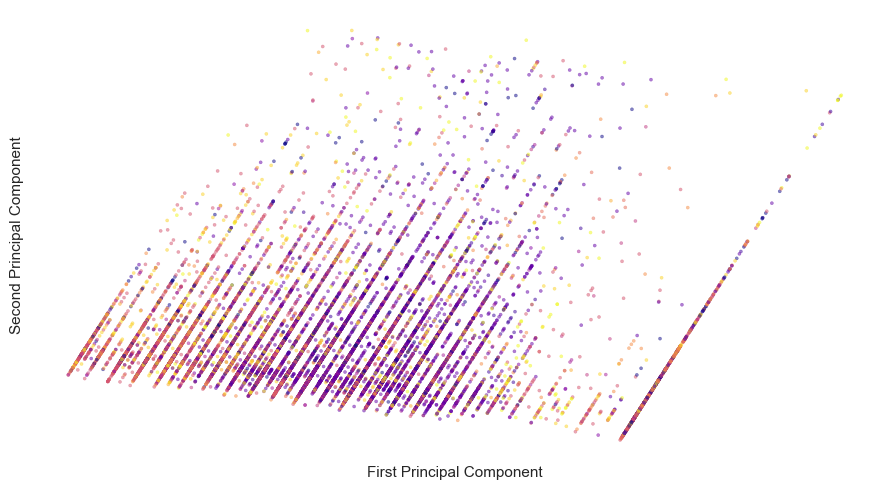

In [12]:
fig = plt.figure(figsize=(9, 5), dpi=100);

axes1 = fig.add_subplot(111);

axes1.scatter(x_pca[:,0], x_pca[:,1], c=y, cmap='plasma', s=5, alpha=0.5)

axes1.set_xlabel('First Principal Component')
axes1.set_ylabel('Second Principal Component')

axes1.set_xticks([])
axes1.set_yticks([])
axes1.grid(False)
axes1.set_facecolor('white');

fig.tight_layout();

<a id='tsvd'></a>

# Truncated SVD

More efficient than PCA for sparse matrices, should provide approximately the same results.

In [13]:
from sklearn.decomposition import TruncatedSVD

In [14]:
x_tsvd = TruncatedSVD(n_components=2).fit_transform(X)

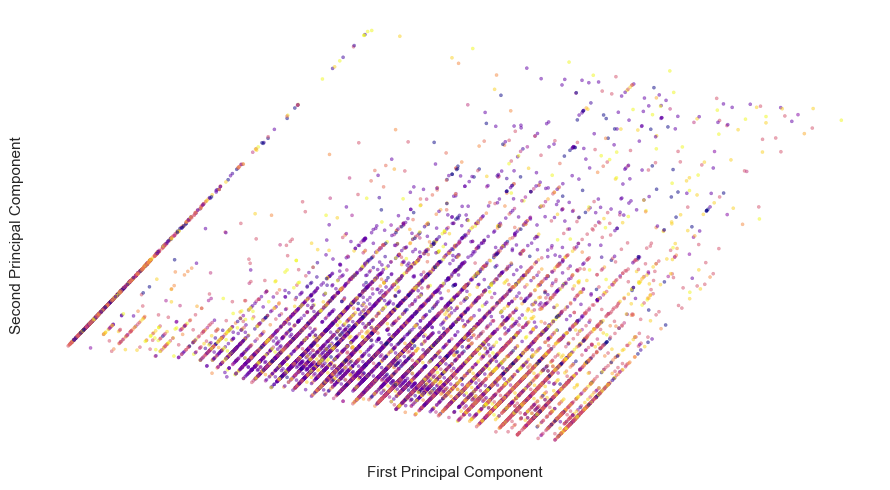

In [15]:
fig = plt.figure(figsize=(9, 5), dpi=100);

axes1 = fig.add_subplot(111);

axes1.scatter(x_tsvd[:,0], x_tsvd[:,1], c=y, cmap='plasma', s=5, alpha=0.5)

axes1.set_xlabel('First Principal Component')
axes1.set_ylabel('Second Principal Component')

axes1.set_xticks([])
axes1.set_yticks([])
axes1.grid(False)
axes1.set_facecolor('white');

fig.tight_layout();

<a id='tsne'></a>

# t-SNE

aka t-distributed Stochastic Neighbor Embedding

We get some really pretty embeddings, signifying potentially complex structure within the dataset, and although the different colors (corresponding to different event types) are a little more seperated, there are still no obvious clusters.

https://distill.pub/2016/misread-tsne/

In [26]:
from sklearn.manifold import TSNE

In [332]:
x_tsvdForTSNE_2 = TruncatedSVD(n_components=2).fit_transform(X)
x_tsvdForTSNE_4 = TruncatedSVD(n_components=4).fit_transform(X)
x_tsvdForTSNE_8 = TruncatedSVD(n_components=8).fit_transform(X)

In [ ]:
tsne = TSNE(n_components=2, method='exact', verbose=1, n_iter=500, n_iter_without_progress=200)

X_embedded_2 = tsne.fit_transform(x_tsvdForTSNE_2)

In [ ]:
X_embedded_4 = tsne.fit_transform(x_tsvdForTSNE_4)

In [ ]:
X_embedded_8 = tsne.fit_transform(x_tsvdForTSNE_8)

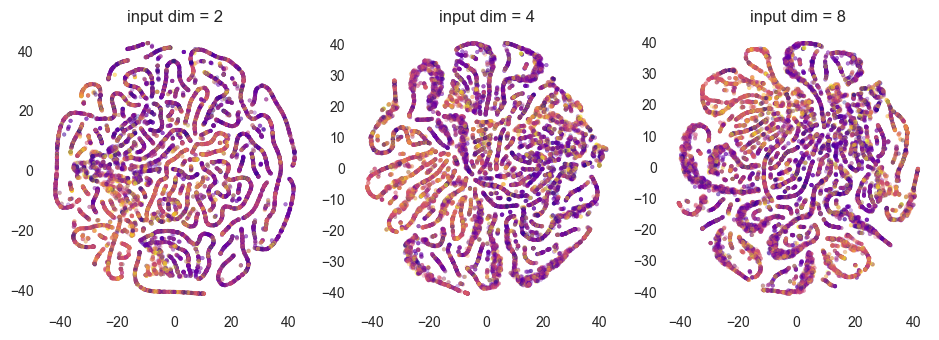

In [342]:
fig = plt.figure(figsize=(9.5, 3.5), dpi=100);

axes1 = fig.add_subplot(131);
axes2 = fig.add_subplot(132);
axes3 = fig.add_subplot(133);

axes1.scatter(X_embedded_2[:,0], X_embedded_2[:,1], c=y, cmap='plasma', s=7, alpha=0.3)
axes2.scatter(X_embedded_4[:,0], X_embedded_4[:,1], c=y, cmap='plasma', s=7, alpha=0.3)
axes3.scatter(X_embedded_8[:,0], X_embedded_8[:,1], c=y, cmap='plasma', s=7, alpha=0.3)

axes1.set_title('input dim = 2');axes2.set_title('input dim = 4');axes3.set_title('input dim = 8');

axes1.grid(False);axes2.grid(False);axes3.grid(False);
axes1.set_facecolor('white');axes2.set_facecolor('white');axes3.set_facecolor('white');

fig.tight_layout();